In [1]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm import tqdm

2024-07-05 10:39:14.274301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 10:39:14.274495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 10:39:14.454223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/deepglobe-road-extraction-dataset/metadata.csv')
data.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [3]:
data = data[data['split']=='train']

In [4]:
len(data)

6226

In [5]:
images = []
masks = []
for i in tqdm(range(6226)):
    path='../input/deepglobe-road-extraction-dataset/'
    image = plt.imread(path+data['sat_image_path'][i])
    mask = plt.imread(path+data['mask_path'][i])
    image = cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask,(128,128),interpolation=cv2.INTER_CUBIC)
    grayimg = mask[:,:,0]*0.2989+mask[:,:,1]*0.5870+mask[:,:,2]*0.1140
    grayimg = tf.expand_dims(grayimg, axis=-1)
    images.append(image)
    masks.append(grayimg)

100%|██████████| 6226/6226 [08:42<00:00, 11.92it/s]


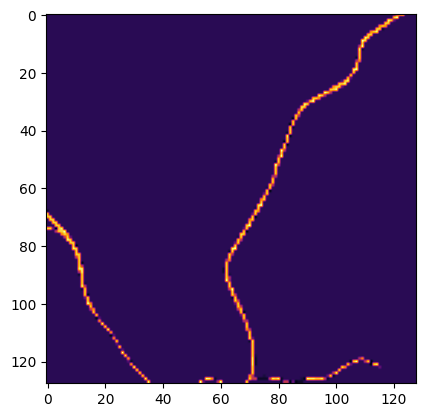

In [6]:
plt.imshow(masks[0],cmap='inferno')
masks = list(masks)

In [7]:
import albumentations as album
def augment(image_size = 128, crop_prob = 1):
    return album.Compose([

        album.RandomCrop(width = image_size, height = image_size, p=crop_prob),
        album.HorizontalFlip(p=0.7),
        album.VerticalFlip(p=0.4),
        album.RandomRotate90(p=0.5),
        album.RandomBrightnessContrast(p=0.6),
        album.RandomGamma(p=0.25),
    ],p=1)

In [8]:
newimgs,newmasks = images.copy(),masks.copy()
for image,mask in tqdm(zip(images,masks)):
    aug = augment()(image=image,mask=mask)
    newimgs.append(aug['image'])
    newmasks.append(aug['mask'])


0it [00:00, ?it/s]


TypeError: mask must be numpy array type

In [ ]:
'''
#conv2d for just UNET no VGG16
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):

    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x
'''


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [ ]:
#conv2d for UNET+ VGG16
def Conv2dBlock(inputTensor, numFilters, kernelSize=3, doBatchNorm=True):
    x = layers.Conv2D(numFilters, (kernelSize, kernelSize), padding='same')(inputTensor)
    if doBatchNorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(numFilters, (kernelSize, kernelSize), padding='same')(x)
    if doBatchNorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [ ]:
#this one has both unet and VGG16 but slow and I didnt have enough time before submission

def GiveMeUnet(inputSize=(128, 128, 3), numFilters=16, dropouts=0.3, doBatchNorm=True):
    inputs = layers.Input(inputSize)

    # VGG16 encoder
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=inputSize)
    for layer in base_model.layers:
        layer.trainable = False

    c1 = base_model.get_layer("block1_conv2").output
    c2 = base_model.get_layer("block2_conv2").output
    c3 = base_model.get_layer("block3_conv3").output
    c4 = base_model.get_layer("block4_conv3").output
    c5 = base_model.get_layer("block5_conv3").output

    # Decoder
    u6 = layers.Conv2DTranspose(numFilters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, doBatchNorm=doBatchNorm)

    u7 = layers.Conv2DTranspose(numFilters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, doBatchNorm=doBatchNorm)

    u8 = layers.Conv2DTranspose(numFilters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, doBatchNorm=doBatchNorm)

    u9 = layers.Conv2DTranspose(numFilters, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropouts)(u9)
    c9 = Conv2dBlock(u9, numFilters, doBatchNorm=doBatchNorm)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[base_model.input], outputs=[outputs])

    return model


In [ ]:

#this one uses UNET
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):

    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [ ]:

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

model = GiveMeUnet(inputSize=(128, 128, 3), numFilters=16, dropouts=0.1, doBatchNorm=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=dice_loss, metrics=['accuracy'])

model.summary()


In [ ]:
'''
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, 0.5), tf.float32)  # Binarize predictions
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32), axis=[1, 2, 3])
    return tf.reduce_mean(intersection / union)
'''

In [ ]:

## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

images=np.array(newimgs)
masks=np.array(newmasks)

In [ ]:
masks.shape

In [ ]:
retVal = unet.fit(images, masks, epochs=10, verbose=1, batch_size=16, validation_split=0.2)

In [ ]:
results = model.evaluate(images, masks, batch_size=16, verbose=1)

print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")


In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, 0.5), tf.float32)  # Binarize predictions
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32), axis=[1, 2, 3])
    return tf.reduce_mean(intersection / union)

In [ ]:
predictions = model.predict(images)

In [ ]:
predictions.shape

In [ ]:
masks.shape

In [ ]:
iou = mean_iou(masks, predictions)
dice = dice_coefficient(masks, predictions)

print(f"Mean IoU: {iou.numpy()}")
print(f"Dice coefficient: {dice.numpy()}")